In [1]:
%%capture
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection


In [64]:
checkpoint = "hustvl/yolos-tiny"
teacher_processor = AutoImageProcessor.from_pretrained(checkpoint)
teacher_model = AutoModelForObjectDetection.from_pretrained(
    checkpoint
)

# pretrained model to start w/ - https://huggingface.co/hustvl/yolos-tiny
# dataset to finetune on - https://huggingface.co/datasets/wider_face

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [4]:
%%capture
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset

train_dataset = load_dataset("wider_face", split="train[:5%]")
test_dataset = load_dataset("wider_face", split="test[:5%]")
validation_dataset = load_dataset("wider_face", split="validation[:5%]")

Generating train split:   0%|          | 0/12880 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/16097 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3226 [00:00<?, ? examples/s]

In [6]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset,
})

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'faces'],
        num_rows: 644
    })
    test: Dataset({
        features: ['image', 'faces'],
        num_rows: 805
    })
    validation: Dataset({
        features: ['image', 'faces'],
        num_rows: 161
    })
})

In [8]:
%%capture
!pip install -U albumentations opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.1
    Uninstalling albumentations-1.3.1:


In [12]:
example = dataset["train"][2]

example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 'faces': {'bbox': [[78.0, 221.0, 7.0, 8.0],
   [78.0, 238.0, 14.0, 17.0],
   [113.0, 212.0, 11.0, 15.0],
   [134.0, 260.0, 15.0, 15.0],
   [163.0, 250.0, 14.0, 17.0],
   [201.0, 218.0, 10.0, 12.0],
   [182.0, 266.0, 15.0, 17.0],
   [245.0, 279.0, 18.0, 15.0],
   [304.0, 265.0, 16.0, 17.0],
   [328.0, 295.0, 16.0, 20.0],
   [389.0, 281.0, 17.0, 19.0],
   [406.0, 293.0, 21.0, 21.0],
   [436.0, 290.0, 22.0, 17.0],
   [522.0, 328.0, 21.0, 18.0],
   [643.0, 320.0, 23.0, 22.0],
   [653.0, 224.0, 17.0, 25.0],
   [793.0, 337.0, 23.0, 30.0],
   [535.0, 311.0, 16.0, 17.0],
   [29.0, 220.0, 11.0, 15.0],
   [3.0, 232.0, 11.0, 15.0],
   [20.0, 215.0, 12.0, 16.0]],
  'blur': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  'expression': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'illumination': [0,
   0,
   0,
   0,
   0,
 

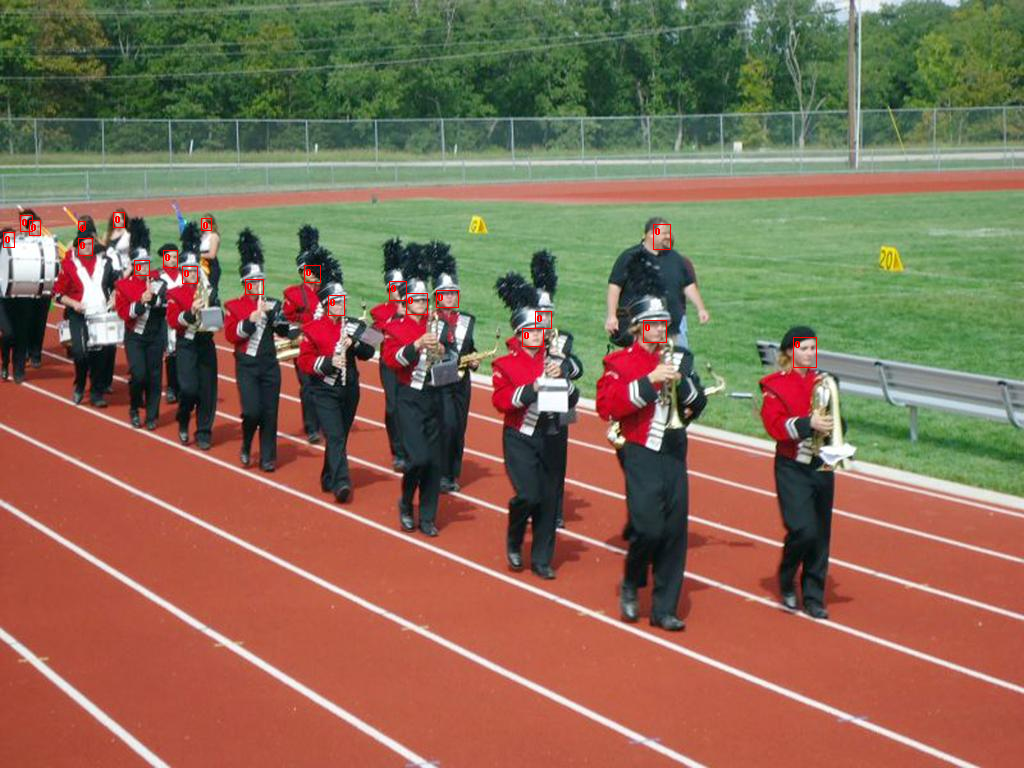

In [38]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

boxes_xywh = torch.tensor(example['faces']['bbox'])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [str(x) for x in example['faces']['expression']]
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(example['image']),
        boxes_xyxy,
        colors="red",
        labels=labels
    )
)

In [43]:
import albumentations
import numpy as np

transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['expression']))

image = np.array(example['image'])
out = transform(
    image=image,
    bboxes=example['faces']['bbox'],
    expression=example['faces']['expression']
)

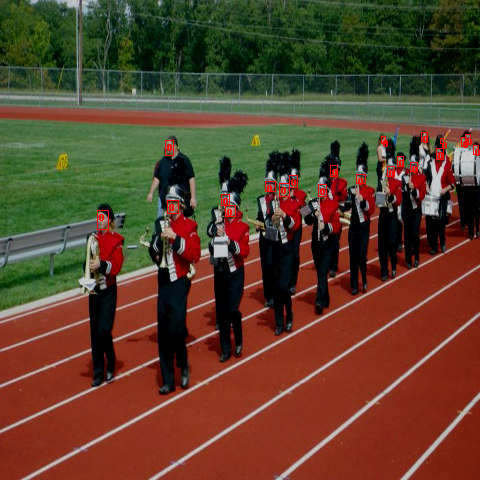

In [45]:
image = torch.tensor(out['image']).permute(2, 0, 1)
boxes_xywh = torch.stack([torch.tensor(x) for x in out['bboxes']])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [str(x) for x in out['expression']]
to_pil_image(
    draw_bounding_boxes(
        image,
        boxes_xyxy,
        colors='red',
        labels=labels
    )
)

In [46]:
def transforms(examples):
    images, bboxes, expressions = [], [], []
    for image, objects in zip(examples['image'], examples['faces']):
        image = np.array(image.convert("RGB"))
        out = transform(
            image=image,
            bboxes=objects['bbox'],
            expression=objects['expression']
        )
        images.append(torch.tensor(out['image']).permute(2, 0, 1))
        bboxes.append(torch.tensor(out['bboxes']))
        expressions.append(out['expression'])
    return {'image': images, 'bbox': bboxes, 'expression': expressions}

In [47]:
dataset['train'].set_transform(transforms)

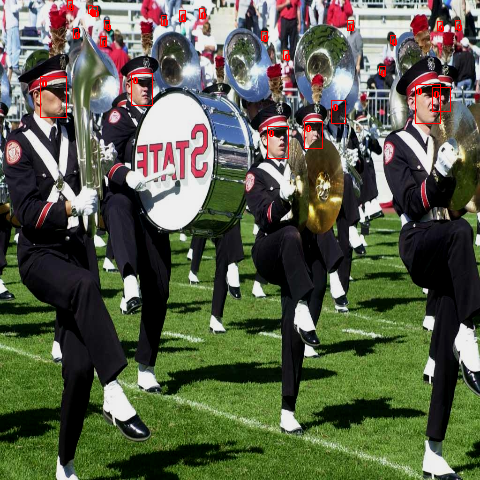

In [52]:
# now whole dataset should be preprocessed
example = dataset['train'][400]
to_pil_image(
    draw_bounding_boxes(
        example['image'],
        box_convert(example['bbox'], 'xywh', 'xyxy'),
        colors='red',
        labels=[str(x) for x in example['expression']]
    )
)

In [68]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="finetuned-tiny-yolo-face",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [67]:
from transformers import Trainer

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=dataset["train"],
    tokenizer=teacher_processor,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


TypeError: YolosImageProcessor.pad() got an unexpected keyword argument 'padding'